In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
from ctypes import *
import time
%matplotlib inline

In [2]:
class blockington(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        stride = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [3]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            blockington(1, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
def train():
    global running_loss
    for epoch in range(10000):
        dataset = []
        raw_dataset = a()
        length = bfs.gameSim(raw_dataset)
        for row_index in range(length):
            temp = []
            for col_index in range(row_index):
                t = (raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2], raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2 + 1])
                temp.append(t)
            dataset.append(temp)

        for sample in dataset:
            rand = int(np.random.rand() * len(train_set))
            sample.append(length/900)
            train_set.append(sample)
            if len(train_set) > 10000:
                train_set.remove(train_set[rand])

        batch = torch.zeros(1, 1, 30, 30, device=device)
        labels = torch.zeros(batch_size, 1, device=device)

        for i in range(batch_size):
            rand = int(np.random.rand() * len(train_set))
            sample = train_set[rand][:len(train_set[rand]) - 1]
            labels[i] = train_set[rand][len(train_set[rand]) - 1:][0]
            board = torch.zeros(board_size, board_size, device=device)
            for number, tupl in enumerate(sample):
                board[tupl] = ((number + 1)/len(sample))
            batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)

        batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
        optimizer.zero_grad()
        outputs = model(batch) #(length, moves)
        loss = loss_function(outputs, labels)
        running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
        losses.append(running_loss)
        loss.backward()
        optimizer.step()

In [5]:
@torch.no_grad()
def dist():
    y = np.zeros(900)
    
    for i in train_set:
        y[int(i[len(i)-1]*900)] += 1
    #     raw_dataset = a()
    #     length = bfs.gameSim(raw_dataset)
    #     y[length] += 1
    # print(np.argmax(y))
    x = np.arange(900)
    plt.bar(x, y, width=1)
    plt.show()

In [6]:
@torch.no_grad()
def eval(xs, ys):
    total_eval_loss = 0
    model.eval()
    for index, val in enumerate(train_set):
        board = torch.zeros(board_size, board_size, device=device)
        eval_loss = 0
        sample = val[:len(val) - 1]
        label = val[len(val) - 1:][0]
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))

        output = (model(board.view(1, 1, board_size, board_size)))
        output_float = float(output.item())

        eval_loss = np.power((output_float - label), 2)
        total_eval_loss += eval_loss

        xs.append(output_float*900)
        ys.append(label*900)

    plt.xlabel("predicted score")
    plt.ylabel("actual score")
#     plt.xlim([50, 250])
#     plt.ylim([50, 250])
    plt.plot(np.arange(50, 250), np.arange(50, 250), color="orange")
    plt.scatter(xs, ys)
    print("eval_loss: " + str(total_eval_loss/10000))
    model.train()

In [18]:
@torch.no_grad()
def loss():
    smooth = 1
    start = 500
    x = np.arange(len(losses)/smooth)
    y = torch.tensor(losses).view(smooth, -1).mean(0)
    c, b = np.polyfit(x[start:], y[start:], 1)
    plt.plot(x[start:], y[start:])
    plt.plot(x[start:], c*x[start:]+b)

In [8]:
# init
torch.cuda.set_device(0)

board_size = 30
device = torch.device('cuda')
batch_size = 128
# ctypes init
bfs = CDLL("./bfs.so")
a = c_int * (900 * 450 * 2)

model = torch.load("model.pt")
# model = resnet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # reiniting adam is pretty bad (avoid)
optimizer.load_state_dict(torch.load("optimizer_state_dict.pt"))

losses = []
train_set = []
model.to(device)
running_loss = 0.1

loss_function = nn.MSELoss()

In [22]:
train()

KeyboardInterrupt: 

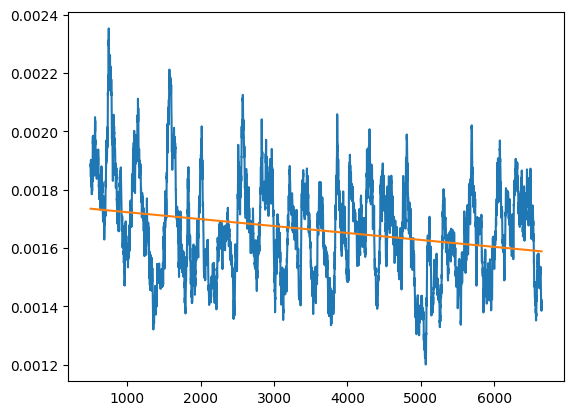

In [23]:
loss()

eval_loss: 0.0015495888596596574


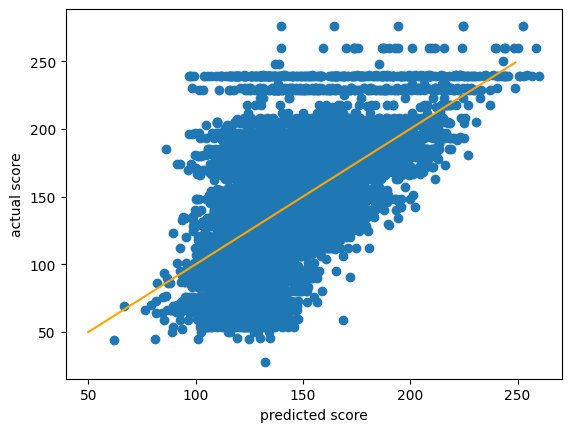

In [24]:
xs = []
ys = []

eval(xs, ys)

In [88]:
torch.save(model, "model.pt")
torch.save(optimizer.state_dict(), "optimizer_state_dict.pt")